In [37]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

np.random.seed(5)

def processed_data(name, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111, stratify=y)
    
    # Preprocessing the data between 0 and 1
    scaler = preprocessing.MinMaxScaler(feature_range=[0,100]).fit(X)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return {'name':name, 'X_train':X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

def credit_data():
    data=np.genfromtxt('../dataset/german.data-numeric.txt') 
    X,y = data[:,:-1], data[:,-1:].squeeze() 
    return processed_data('credit-g',X, y)

def banknote_data():
    data=np.genfromtxt('../dataset/data_banknote_authentication.txt', delimiter=',') 
    X,y = data[:,:-1], data[:,-1:].squeeze() 
    return processed_data('banknote',X,y)

def wine_data():
    data=np.genfromtxt('../dataset/winequality-white.csv', delimiter=';', skip_header=1)
    X,y = data[:,:-1], data[:,-1:].squeeze()
    return processed_data('wine-quality',X,y)
    
# def wine_data():
#     data=np.genfromtxt('../dataset/winequality.csv', delimiter=';')
#     X,y = data[:,:-1], data[:,-1:].squeeze()
#     return processed_data('wine-quality',X,y)

def iris_data():
    from sklearn.datasets import load_iris
    data = load_iris()
    X,y = data.data, data.target
    return processed_data('iris',X,y)


cdata = credit_data()
bdata = banknote_data()
idata = iris_data()
wdata = wine_data()

def elbow_curve(dataset_name, X, n_clusters_range=list(range(1, 50))):
    wcss = []

    for i in n_clusters_range:
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    #Plotting the results onto a line graph, allowing us to observe 'The elbow'
    plt.plot(n_clusters_range, wcss)
    plt.title('The elbow Method for Optimal k (%s)'%dataset_name)
    plt.xlabel('Number of clusters')
    plt.ylabel('within-cluster sum-of-squares') #within cluster sum of squares
    plt.show()

def bench_k_means(estimator, name, data, labels, sample_size):
    t0 = time()
    estimator.fit(data)
    
    cluster_labels = estimator.labels_
        
    return {
        'init': name,
        'time': (time() - t0),
        'accuracy': metrics.accuracy_score(labels, cluster_labels),
        'precision': metrics.precision_score(labels, cluster_labels, average="weighted"),
        'recall': metrics.recall_score(labels, cluster_labels, average="weighted"),
        'f1_score': metrics.f1_score(labels, cluster_labels, average="weighted"),
        'homogenity': metrics.homogeneity_score(labels, cluster_labels),
        'completeness': metrics.completeness_score(labels, cluster_labels),
        'v-measure': metrics.v_measure_score(labels, cluster_labels),
        'ARI': metrics.adjusted_rand_score(labels, cluster_labels),
        'AMI': metrics.adjusted_mutual_info_score(labels,  cluster_labels),
        'mutual_info': metrics.mutual_info_score(labels,  cluster_labels),
        'NMI': metrics.cluster.normalized_mutual_info_score(labels, cluster_labels),
        'silhouette': metrics.silhouette_score(data, cluster_labels)
    }

def k_means_performance_curve(dataset_name,n_clusters_range, data, labels):
    n_samples, n_features = data.shape
    n_classes = len(np.unique(labels))
    sample_size = n_samples

    vals = []
    for n in n_clusters_range:
        estimator = KMeans(init='k-means++', n_clusters=n, max_iter = 300, n_init = 10, random_state = 0)
        _bench = bench_k_means(estimator, name="k-means++", data=data, labels=labels, sample_size=sample_size)
        _bench['n_clusters'] = n
        vals.append(_bench)

    df = pd.DataFrame(vals)    
    ax1 = df.plot(x='n_clusters', 
                  y=['silhouette'], 
                  title="K Means Silhoutte Score %s"%dataset_name)
    ax1.set_xlabel("Number of clusters")
    plt.show()
        
    df = pd.DataFrame(vals)    
    ax1 = df.plot(x='n_clusters', 
                  y=['ARI','v-measure','AMI', 'mutual_info' ], 
                  title="K Means Performance evaluation %s"%dataset_name)
    ax1.set_xlabel("Number of clusters")
    plt.show()

def bench_em(estimator, name, data, labels, sample_size):
    t0 = time()
    estimator.fit(data)
    
    cluster_labels = estimator.predict(data)
        
    return {
        'init': name,
        'time': (time() - t0),
        'accuracy': metrics.accuracy_score(labels, cluster_labels),
        'precision': metrics.precision_score(labels, cluster_labels, average="weighted"),
        'recall': metrics.recall_score(labels, cluster_labels, average="weighted"),
        'f1_score': metrics.f1_score(labels, cluster_labels, average="weighted"),
        'homogenity': metrics.homogeneity_score(labels, cluster_labels),
        'completeness': metrics.completeness_score(labels, cluster_labels),
        'v-measure': metrics.v_measure_score(labels, cluster_labels),
        'ARI': metrics.adjusted_rand_score(labels, cluster_labels),
        'AMI': metrics.adjusted_mutual_info_score(labels,  cluster_labels),
        'mutual_info': metrics.mutual_info_score(labels,  cluster_labels),
        'NMI': metrics.cluster.normalized_mutual_info_score(labels, cluster_labels),
        'silhouette': metrics.silhouette_score(data, cluster_labels),
        'aic': estimator.aic(data),
        'bic': estimator.bic(data)
    }
    
def em_performance_curve(dataset_name,n_clusters_range, data, labels):
    n_samples, n_features = data.shape
    n_classes = len(np.unique(labels))
    sample_size = n_samples

    vals = []
    for n in n_clusters_range:
        estimator = EM(n_components=n,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
        _bench = bench_em(estimator, name="k-means++", data=data, labels=labels, sample_size=sample_size)
        _bench['n_clusters'] = n
        vals.append(_bench)

    df = pd.DataFrame(vals)    
    ax1 = df.plot(x='n_clusters', 
                  y=['silhouette'], 
                  title="K Means Silhoutte Score %s"%dataset_name)
    ax1.set_xlabel("Number of clusters")
    plt.show()
        
    df = pd.DataFrame(vals)    
    ax1 = df.plot(x='n_clusters', 
                  y=['ARI','v-measure','AMI', 'mutual_info','aic','bic' ], 
                  title="K Means Performance evaluation %s"%dataset_name)
    ax1.set_xlabel("Number of clusters")
    plt.show()
    
    
def silhouette_plot(dataset_name, range_n_clusters, data, labels):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(data)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for %s n_clusters=%s"%(dataset_name,n_clusters))
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data[:, 0], data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on %s dataset "
                      "with n_clusters = %d" % (dataset_name,n_clusters)),
                     fontsize=14, fontweight='bold')

    plt.show()
    
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title("GMM with %d components"%len(gmm.means_), fontsize=(20))
    plt.xlabel("U.A.")
    plt.ylabel("U.A.")

def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [200]:
def k_means_analysis(data, labels):
    elbow_curve(data, n_clusters_range=list(range(1, 10)))
    n_clusters_range = [2,3,4,5,6,7,8,9,10]
    k_means_performance_curve(n_clusters_range, data, labels)
    silhouette_plot(n_clusters_range, data, labels=labels)

In [201]:
estimator = KMeans(init='k-means++', n_clusters=2, max_iter = 300, n_init = 10, random_state = 0)
_bench = bench_k_means(estimator, name="k-means++", data=wdata['X_train'], labels=wdata['y_train'], sample_size=wdata['X_train'].shape[0])

[1 0 1 ... 0 1 0]
[1 0 1 ... 0 1 0]


In [17]:
%%cache
%%capture
elbow_curve(cdata['name'],cdata['X_train'], n_clusters_range=list(range(1, 15)))
elbow_curve(wdata['name'],wdata['X_train'], n_clusters_range=list(range(1, 40)))

In [150]:
%%cache
%%capture
n_clusters_range = [2,3,4,5,6,7,8,9,10]
silhouette_plot(cdata['name'],n_clusters_range, cdata['X_train'], labels=cdata['y_train'])


In [14]:
%%cache
%%capture
n_clusters_range = [2,3,4,5,6,7,8,9,10,12,14]
silhouette_plot(wdata['name'],n_clusters_range, wdata['X_train'], labels=wdata['y_train'])

In [15]:
%%cache
%%capture
n_clusters_range = list(range(2,50,5))
k_means_performance_curve(cdata['name'], n_clusters_range, cdata['X_train'], cdata['y_train'])

In [16]:
%%cache
%%capture
n_clusters_range = list(range(2,50,5))
k_means_performance_curve(wdata['name'], n_clusters_range, wdata['X_train'], wdata['y_train'])

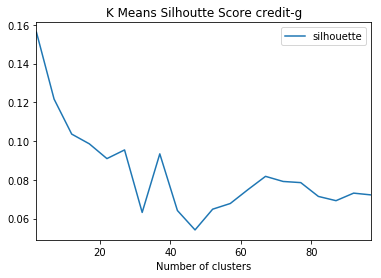

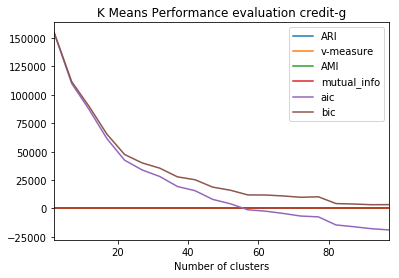

In [38]:
n_components_range = list(range(2,100,5))
em_performance_curve(cdata['name'], n_components_range, cdata['X_train'], cdata['y_train'])